# Домашнее задание 5
В этом задании мы:

1. Построим U-Net для датасета VOC segmentation, посмотрим на качество семантической сегментации.
2. Соберем GAN для генерации картинок из MNIST.
3. Прикрутим к этому GAN обуславливание на метку класса, посмотрим на результат.

## U-Net на датасете VOC

Датасет [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) - один из классических датасетов для задачи семантической сегментации.
Его используют в статьях и [по сей день](https://paperswithcode.com/dataset/pascal-voc) для бенчмарков.

В этом задании вам нужно скачать этот датасет, разбить на train и validation части, и обучить на нем U-Net.
Код для U-Net разбирался в семинаре.

В ЛМС необходимо сдать вашу реализацию U-Net и `model.pt` файл обученной модели.
Чтобы сдать это задание, модель должна достигать accuracy > 50% на тестовом датасете.

In [1]:
import typing as tp
from functools import reduce
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from albumentations.pytorch.transforms import ToTensorV2
from IPython.display import clear_output, display
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation

100%|██████████| 2.00G/2.00G [01:21<00:00, 24.5MB/s]


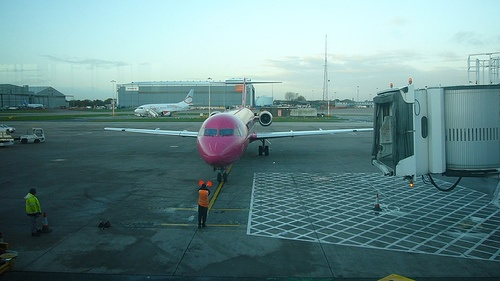

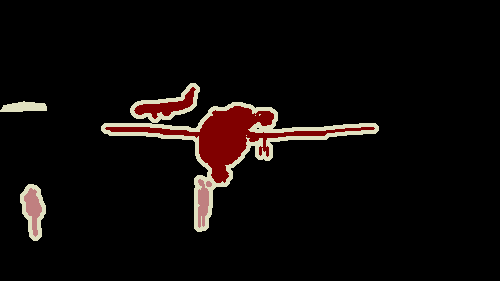

In [2]:
# Для начала загрузим датасет и посмотрим на его структуру
dataset = VOCSegmentation(
    root="./data",
    year="2012",
    image_set="train",
    download=not Path("./data").exists(),
)
display(dataset[0][0])
display(dataset[0][1])

В датасете маске присваивается 255 для границы объекта, а внутри объекта присваивается число от 0 до 20 - метка класса.

In [3]:
# Пройдемся по всем маскам датасета и возьмем уникальные значения в пикселях
reduce(
    lambda s1, s2: s1.union(s2),
    (set(np.unique(np.array(dataset[i][1])).tolist()) for i in range(len(dataset))),
    set(),
)
# Ага, действительно, метки классов от 0 до 20, при этом 0 означает "ничего интересного нет", а 255 означает границу

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 255}

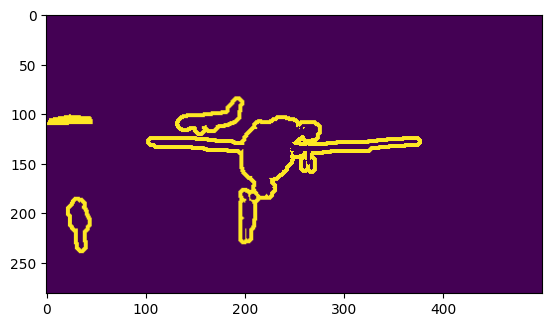

In [4]:
# Отрисуем только пиксели со значением 255 и убедимся, что они соответствуют границам объектов
plt.imshow(np.where(np.array(dataset[0][1]) == 255, 1, 0))

<ipython-input-5-26ebbea1a44e>:9: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda( # A.lambda кладет в labda значения


(tensor([[[0.5137, 0.5137, 0.5216,  ..., 0.7176, 0.7137, 0.7137],
         [0.5176, 0.5176, 0.5255,  ..., 0.7216, 0.7176, 0.7176],
         [0.5216, 0.5216, 0.5255,  ..., 0.7216, 0.7176, 0.7176],
         ...,
         [0.0392, 0.0314, 0.0431,  ..., 0.0235, 0.0353, 0.0314],
         [0.0235, 0.0196, 0.0353,  ..., 0.0549, 0.0588, 0.0627],
         [0.0196, 0.0353, 0.0431,  ..., 0.0667, 0.0588, 0.0667]],

        [[0.7569, 0.7569, 0.7647,  ..., 0.9137, 0.9098, 0.9098],
         [0.7608, 0.7608, 0.7686,  ..., 0.9176, 0.9137, 0.9137],
         [0.7647, 0.7647, 0.7686,  ..., 0.9176, 0.9137, 0.9137],
         ...,
         [0.0627, 0.0549, 0.0588,  ..., 0.0980, 0.1059, 0.1059],
         [0.0588, 0.0549, 0.0549,  ..., 0.1294, 0.1294, 0.1333],
         [0.0549, 0.0706, 0.0627,  ..., 0.1412, 0.1294, 0.1373]],

        [[0.8157, 0.8157, 0.8235,  ..., 0.9412, 0.9451, 0.9451],
         [0.8196, 0.8196, 0.8275,  ..., 0.9451, 0.9490, 0.9490],
         [0.8235, 0.8235, 0.8275,  ..., 0.9451, 0.9490, 0

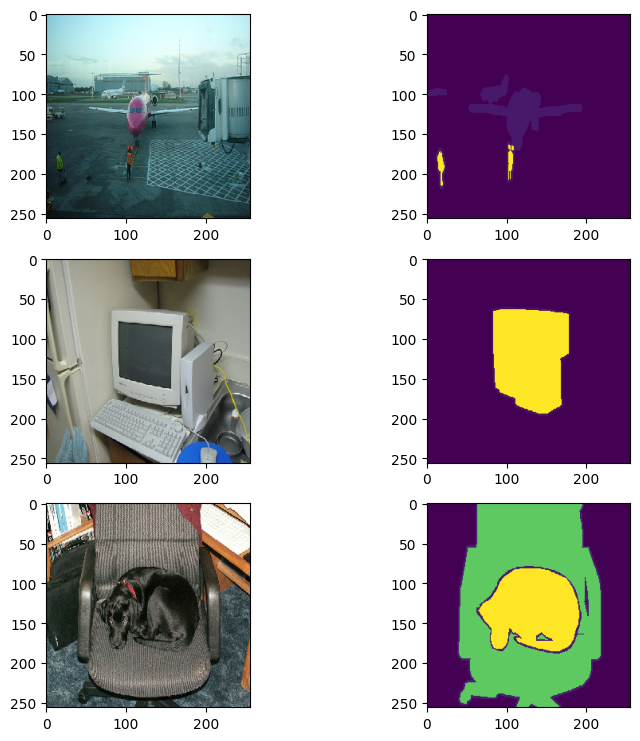

In [5]:
n_classes, img_size = 22, 256

# литерал проверяет чтобы туда входил объект только с таким именем "вал трейн тест"
def load_voc_dataset(split: tp.Literal["train", "val", "test"]):
    transforms = A.Compose( # удобная штука которая проводит операции ниже над изображением и маской вместе
        [
            A.Resize(img_size, img_size, interpolation=cv2.INTER_NEAREST), # интерполяция(cv2.INTER_NEAREST) способ как он накидывает пустые пиксели при рейсайзе
            ToTensorV2(),
            A.Lambda( # A.lambda кладет в labda значения
                # Нормализуем изображение в отрезок [0, 1]
                image=lambda image, **_: image / 255.0,
                # Сделайте так, чтобы все классы шли друг от друга с шагом 1 (подумайте, что делать с классом 255)
                mask=lambda mask, **_: torch.where(mask == 255, 1, mask), #функция np.where(условие, если_да, если_нет)
            ),
        ]
    )

    def _transform(image, mask):
        # Конвертируем из PIL формата в np.array за счет np.array(image).
        # Заметьте, image=..., mask=... - это указание, что есть изображение и что есть маска.
        # Albumentations в общем виде по-разному обрабатывает изображения и маски.
        transformed = transforms(image=np.array(image), mask=np.array(mask))
        return transformed["image"], transformed["mask"]

    # Создание датасета с нужными трансформациями
    dataset = VOCSegmentation(
        root="./data",
        year="2012",
        image_set=split,
        download=not Path("./data").exists(),
        transforms=_transform,
    )
    return dataset


train_dataset = load_voc_dataset("train")
val_dataset = load_voc_dataset("val")
print(train_dataset[0])
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

# Отрисовка изображения и маски
fig, ax = plt.subplots(3, 2, figsize=(9, 9))
for i in range(3):
    img, mask = train_dataset[i]
    ax[i][0].imshow(img.permute(1, 2, 0).numpy())
    ax[i][1].imshow(mask.numpy())
fig.show();

Теперь очередь за вами.
Обучите модель и сдайте её в ЛМС (инструкции выше).

Обратите внимание, что границы объекта выделены пикселем 255 - это немного выбивается из остальных классов, где метки идут с шагом 1 (0, 1, 2 и т.д. до 21).
Подумайте, как это исправить.

In [6]:
# даталоадер

from torch.utils.data import DataLoader

seed = 0
batch_size = 4
n_steps_before_backward = 8

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)




In [7]:
from functools import reduce

import torch.nn as nn
import torch.nn.functional as F
import tqdm
import wandb
from torch.optim import Adam


def calc_accuracy(model: nn.Module, loader: DataLoader, device: torch.device):
    count_correct, count_total = 0, 0
    model.eval()
    for img_batch, true_labels in loader:
        img_batch = img_batch.to(device)
        true_labels = true_labels.to(device)
        with torch.no_grad():
            prediction = model(img_batch)
        # (B, K, H, W)
        # pred_labels = (prediction > 0).squeeze(1)
        pred_labels = torch.argmax(prediction, dim=1)
        count_correct += (pred_labels == true_labels).sum().item()
        # произведение всех размерностей
        count_total += reduce(lambda a, b: a * b, true_labels.shape, 1)
    model.train()
    return count_correct / count_total


def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    lr = 1e-3
    n_epochs = 2
    eval_every = 20
    optimizer = Adam(model.parameters(), lr=lr)
    model.to(device)
    criterion = nn.CrossEntropyLoss(reduction="none")

    for epoch in range(n_epochs):
        print(f"Epoch #{epoch + 1}/#{n_epochs}")
        for i, (img_batch, true_labels) in enumerate(tqdm.tqdm(train_loader)):
            optimizer.zero_grad()
            step = epoch * len(train_loader) + i
            img_batch, true_labels = img_batch.to(device), true_labels.to(device)

            pred_labels = model(img_batch).squeeze()
            loss = criterion(pred_labels, true_labels.long()).mean()
            loss.backward()

            # Будем не каждую итерацию делать шаг спуска.
            # Это увеличит batch_size без необходимости вмещать больше в память.
            optimizer.step()

            wandb.log({"loss": loss.cpu().item()}, step=step)
            if (i + 1) % eval_every == 0:
                wandb.log(
                    {"accuracy": calc_accuracy(model, val_loader, device)}, step=step
                )
        wandb.log({"accuracy": calc_accuracy(model, val_loader, device)}, step=step)



# Имплементация U-Net, взято из https://github.com/milesial/Pytorch-UNet
# Распространяется под лицензией GPL-3.0
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)




class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x: torch.Tensor, x_left: torch.Tensor):
        x = self.up(x)
        # Западдим картинку снизу, если размерности отличаются
        diffY = x_left.shape[2] - x.shape[2]
        diffX = x_left.shape[3] - x.shape[3]

        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x_left, x], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(3, n_classes)

In [8]:
wandb.init(project="start-dl-lesson-5", name="simple-model")
train_loop(model, train_loader, val_loader, device=device)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:


Abort: 

In [ ]:
torch.save(model.state_dict(), "model.pt")

In [ ]:
from google.colab import files
files.download('model.pt')

## GAN на MNIST

Во второй части задания мы попробуем генерировать изображения с цифрами.
Для этого возьмем модель GAN и обучим ее на датасет MNIST.

Ваша задача: скачайте датасет MNIST, обучите на нем GAN, сохраните веса генератора и дискриминатора в `generator.pt` и `discriminator.pt` соответственно.
Сдайте в ЛМС:
1. Код генератора и его веса.
2. Код дискриминатора и его веса.

In [9]:
# Используйте следующие параметры модели
image_size = 64
# Размер латентного вектора - из него генератор будет создавать изображение
nz = 100

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from dataclasses import dataclass

torch.manual_seed(987)

In [11]:
# Загружаем датасет с картинками одежды FashionMNIST
# root- путь
# train- трейновая часть
# download- если отсутствует то загрузить?
# transofrm преобразуем сразу в тензор

train_dataset = MNIST(
    root="./data", train=True, download=True, transform=ToTensor()
)
test_dataset = MNIST(
    root="./data", train=False, download=True, transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.35MB/s]


In [43]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

seed = 0
batch_size = 4
n_steps_before_backward = 8

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = MNIST(
    root="./data", train=False, download=True, transform=transform
)

In [29]:
dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=6
)

In [30]:
dataroot = "data/"
batch_size = 256
image_size = 28
nc = 1
# Размер латентного вектора - из него генератор будет создавать изображение
nz = 100
# Размер feature map в генераторе
ngf = 64
# Размер feature map в дискриминаторе
ndf = 64
num_epochs = 3
lr = 0.0002
beta1 = 0.5

In [31]:
# Инициализация весов
# Это советуют делать в оригинальной статье https://arxiv.org/abs/1511.06434
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

netG = Generator().to(device)
netG.apply(weights_init)
print(netG)



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)


criterion = nn.BCELoss()

# Рисовать картинки будем из одного и того же шума, чтобы суметь сравнить разные итерации
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Метки для настоящего и фальшивого изображения
real_label, fake_label = 1., 0.

optimizerD = Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))




img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Максимизируем по дискриминатору log(D(x)) + log(1 - D(G(z)))
        # Шаг по реальной картинке
        netD.zero_grad()
        real_batch = data[0].to(device)
        b_size = real_batch.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_batch).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Шаг по фальшивой картинке
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Максимизируем по генератору log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(dataloader),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(dataloader) - 1)
        ):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1






In [ ]:
torch.save(netG.state_dict(), "generator.pt")
torch.save(netD.state_dict(), "discriminator.pt")

In [ ]:
from google.colab import files
files.download('generator.pt')

In [ ]:
from google.colab import files
files.download('discriminator.pt')

## GAN с условиями

Наш GAN генерирует картинку из случайного класса.
Однако можно научить его принимать на вход метку класса и генерировать картинку с этой меткой.
Такие GAN называются **Conditional GAN** (*обусловленный GAN*).

Добавить обуславливание достаточно просто:
1. Добавьте в генератор embedding-слой для метки класса. Берите небольшую размерность вектора, 10-ти хватит.
2. Поменяйте первый ConvTranspose2d так, чтобы тот принял вектор длины 110 (100 от рандома, 10 от эмбеддинга).
3. Поменяйте код `forward` так, чтобы в ConvTranspose2d передавать объединенный вектор размера 110.
4. Сделайте аналогичные изменения в `Discriminator` - он тоже должен принимать `label` как аргумент в `forward` и учитывать его. Подумайте, какие слои и как надо будет поменять.

Сделайте **Conditional GAN**, обучите его.
Сдайте в ЛМС:
1. Новый код `Generator` и его веса.
2. Новый код `Discriminator` и его веса.

In [21]:
nz = 100           # размер латентного вектора (шум)
num_classes = 10   # для MNIST
embed_size = 10    # размер эмбеддинга метки
ngf = 64           # размер feature map генератора
nc = 1             # grayscale (MNIST)
ndf = 64



In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader
import torchvision.utils as vutils

# ——— Гиперпараметры ———
nz = 100
num_classes = 10
embed_size = 10
ngf = 64
ndf = 64
nc = 1
image_size = 64
batch_size = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ——— Трансформы и датасет ———
transform = Compose([
    Resize(image_size),
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ——— Инициализация весов ———
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# ——— Генератор ———
class ConditionalGenerator(nn.Module):
    def __init__(self, nz, num_classes, embed_size, ngf, nc):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embed_size)
        self.fc = nn.Linear(nz + embed_size, ngf * 8 * 1 * 1)
        self.ngf = ngf

        self.net = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),  # ← 32 → 64
            nn.Tanh()
          )


    def forward(self, z, labels):
        label_embed = self.label_emb(labels)
        x = torch.cat((z, label_embed), dim=1)
        x = self.fc(x).view(-1, self.ngf * 8, 1, 1)
        out = self.net(x)
        print(f"[GEN DEBUG] output shape: {out.shape}")  # 👈 вставь вот это
        return out

# ——— Дискриминатор ———
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, embed_size, nc, ndf):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, embed_size)
        self.fc = nn.Linear(embed_size, 64 * 64)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),  # 1 → 2
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),  # 2 → 4
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1),      # 4 → 8
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, ngf // 2, 4, 2, 1),     # 8 → 16
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf // 2, nc, 4, 2, 1),      # 16 → 32
            nn.Tanh(),

            nn.ConvTranspose2d(nc, nc, 4, 2, 1),            # 32 → 64
            nn.Tanh()
        )


    def forward(self, x, labels):
        label_embed = self.fc(self.label_embed(labels)).view(-1, 1, 64, 64)
        print(f"[DEBUG] x shape: {x.shape}")
        print(f"[DEBUG] label_embed shape: {label_embed.shape}")

        x = torch.cat((x, label_embed), dim=1)
        return self.net(x)

# ——— Модели ———
netG = ConditionalGenerator(nz, num_classes, embed_size, ngf, nc).to(device)
netD = ConditionalDiscriminator(num_classes, embed_size, nc, ndf).to(device)
netG.apply(weights_init)
netD.apply(weights_init)

# ——— Обучение ———
criterion = nn.BCELoss()
optimizerG = Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
fixed_noise = torch.randn(64, nz, device=device)
fixed_labels = torch.randint(0, num_classes, (64,), device=device)

for epoch in range(num_epochs):
    for i, (real_images, real_labels) in enumerate(dataloader):
        real_images, real_labels = real_images.to(device), real_labels.to(device)
        b_size = real_images.size(0)
        real_targets = torch.full((b_size,), 1.0, device=device)
        fake_targets = torch.full((b_size,), 0.0, device=device)

        # — Train Discriminator —
        netD.zero_grad()
        output_real = netD(real_images, real_labels).view(-1)
        loss_real = criterion(output_real, real_targets)

        noise = torch.randn(b_size, nz, device=device)
        fake_images = netG(noise, real_labels)
        output_fake = netD(fake_images.detach(), real_labels).view(-1)
        loss_fake = criterion(output_fake, fake_targets)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizerD.step()

        # — Train Generator —
        netG.zero_grad()
        output = netD(fake_images, real_labels).view(-1)
        loss_G = criterion(output, real_targets)
        loss_G.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(
                f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] "
                f"Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}"
            )

# ——— Сохранение весов ———
torch.save(netG.state_dict(), "generator.pt")
torch.save(netD.state_dict(), "discriminator.pt")



[DEBUG] x shape: torch.Size([64, 1, 64, 64])
[DEBUG] label_embed shape: torch.Size([64, 1, 64, 64])


RuntimeError: Given transposed=1, weight of size [512, 256, 4, 4], expected input[64, 2, 64, 64] to have 512 channels, but got 2 channels instead

In [ ]:
torch.save(netG.state_dict(), "generator.pt")
torch.save(netD.state_dict(), "discriminator.pt")

Если вы все сделали правильно, у вас должны получиться правдоподобные картинки для каждого из классов.